# 1d2v-GEMPIC-Vlasov-Maxwell-Solver

## Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import fembase as fem
import picbase as pic
from bsplines import Bspline
from scipy.integrate import fixed_quad
from scipy import integrate
from copy import deepcopy

## Simulation parameters

In [17]:
# wavenumber of perturbations
k = 1.25

# boundaries and lenght of domain
a_boundary = 0
b_boundary = 2*np.pi/k
Lx = b_boundary - a_boundary

# number of elements and element boundaries
Nel = 64
el_b = np.linspace(a_boundary, b_boundary, Nel + 1)

# element size
dx = (b_boundary - a_boundary)/Nel

# degree of basis functions in V0
degree = 3

# degree and width of B-spline smoothing kernel
p = 3
Swidth = 8*Lx/(2*Nel)
dx_S = Swidth/(p + 1)


# number of particles for simulation
Np = np.int(1e6)

Text(0.5,1,'Initial Ex-field')

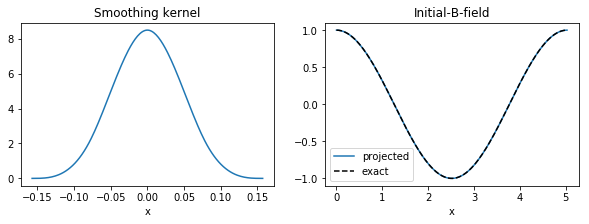

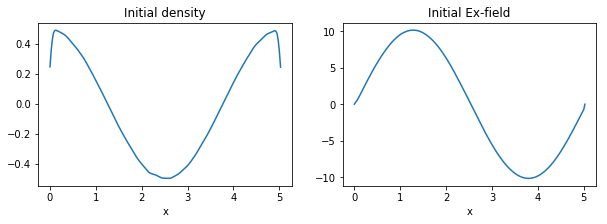

In [18]:
# create and plot smoothing kernel
a_kernel = -(p + 1)/2*dx_S
b_kernel = +(p + 1)/2*dx_S
nodes = np.linspace(a_kernel,b_kernel,p + 2)
le = np.linspace(a_kernel - p*dx_S,a_kernel - dx_S,p)
ri = np.linspace(b_kernel + dx_S,b_kernel + p*dx_S,p)

T = np.array(list(le)  + list(nodes) + list(ri))
bsp_S = Bspline(T,p)


def kernel(x):
    '''Defines the smoothing kernel.
    
    Parameters:
        x : ndarray
            1D-array with positions to be evaluated.
    
    Returns:
        value : ndarray
            1D-array with kernel evaluated at x.
    '''
    
    if x.size != 0: 
        value = 1/dx_S*bsp_S(x,p)
        if (np.abs(x) > Swidth/2).any():
            print('Warning: S evaluated beyond support!')
    else:
        value = np.array([])
    
    return value
        

    
nx = 200
supp = np.linspace(a_kernel,b_kernel,nx)
y = kernel(supp)

f1 = plt.figure()
f1.set_figheight(3)
f1.set_figwidth(10)

plt.subplot(121)
plt.plot(supp,y)
plt.xlabel('x')
plt.title('Smoothing kernel')


# create Lagrange shape functions in V1 and V0 and compute global matrices M0 and M1
shapefun = fem.LagrangeShape(np.linspace(-1, 1, degree + 1))
Nbase_0, mass_0 = fem.lag_assemb(el_b, shapefun.mass0, shapefun.stiff0, bcs = 2)[1:3]
Nbase_1, mass_1 = fem.lag_assemb(el_b, shapefun.mass1, shapefun.stiff1, basis = 2, bcs = 2)[1:3]


# initialize B-field, compute initial coefficients by projection on the basis and check result
beta = 1.

B_0 = lambda x: beta*np.cos(k*x)

x_vec, b = fem.lag_proj(shapefun.s, el_b, B_0)
fun = fem.lag_fun(b, shapefun.chi, el_b, basis = 2)[2]
x_plot = np.linspace(a_boundary, b_boundary, 200)

plt.subplot(122)
plt.plot(x_plot, fun(x2), label = 'projected')
plt.plot(x_plot, B_0(x2), 'k--', label = 'exact')
plt.xlabel('x')
plt.title('Initial-B-field')
plt.legend()

# assemble gradient matrix
grad1 = np.ones(Nbase_0)
grad2 = -np.ones(Nbase_0 - 1)
Grad = np.diag(grad1) + np.diag(grad2, -1)
Grad = np.append(Grad, [np.zeros(Nbase_0)], axis = 0)
Grad[-1, -1] = -1

# assemble gradient matrix_tilde
grad1 = np.ones(Nbase_1 - 1)
grad2 = -np.ones(Nbase_1)
Grad_tilde = np.diag(grad2) + np.diag(grad1, +1)
Grad_tilde[-1, :] = 1

# initialize distribution function and define sampling distribution for initial markers
sigma_1 = 0.02/np.sqrt(2)
sigma_2 = np.sqrt(12)*sigma_1
alpha = 0.5

f0 = lambda x,vx,vy: 1/(2*np.pi*sigma_1*sigma_2)*np.exp(-1/2*(vx**2/sigma_1**2 + vy**2/sigma_2**2))*(1*0 + alpha*np.cos(k*x))
#f0 = lambda x,vx,vy: 1/(2*np.pi*sigma_1*sigma_2)*np.exp(-1/2*(vx**2/sigma_1**2 + vy**2/sigma_2**2))*(alpha*np.sin(k*x))
g0 = lambda x,vx,vy: 1/(2*np.pi*sigma_1*sigma_2)*np.exp(-1/2*(vx**2/sigma_1**2 + vy**2/sigma_2**2))*1/Lx



# create particles and compute weights
particles = np.zeros((Np,4))

particles[:, 0] = np.random.rand(Np)*Lx
particles[:, 1] = np.random.randn(Np)*sigma_1
particles[:, 2] = np.random.randn(Np)*sigma_2

particles[:, 3] = 1/Np*f0(particles[:, 0],particles[:, 1], particles[:, 2])/g0(particles[:, 0],particles[:, 1], particles[:, 2])

# assembly of intitial S and global knot vector
S, x_vec = pic.assemb_S(particles[:, 0], kernel, Swidth, el_b, shapefun.s)
temp = S.dot(particles[:, 3])


# the computation of rho at the boundaries is complicated, because we loose mass at the boundaries due to the finite size of the smoothing kernel
rho = np.zeros(Nbase_1)

for ie in range(Nel):
    jac = 2/(el_b[ie + 1] - el_b[ie])

    for il in range(degree):
        i = ie*degree + il
        
        rho[i] += jac/2*(x_vec[i + 1] - x_vec[i])*(temp[i + 1] + temp[i])
        
# compute E-field
rho_bc = deepcopy(rho)
rho_bc[-1] = 0
ex = np.linalg.solve(Grad_tilde,rho_bc)

f2 = plt.figure()
f2.set_figheight(3)
f2.set_figwidth(10)

dens = fem.lag_fun(rho, shapefun.chi, el_b, basis = 2)[2]
elec = fem.lag_fun(ex, shapefun.eta, el_b, basis = 1)[2]

plt.subplot(121)
plt.plot(x_plot,dens(x_plot))
plt.xlabel('x')
plt.title('Initial density')

plt.subplot(122)
plt.plot(x_plot,elec(x_plot))
plt.xlabel('x')
plt.title('Initial Ex-field')